# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [2]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [11]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes), kernel_size=1, stride=1, padding=0, bias=False)
        
    
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]

        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*0.1
        a=torch.randn(1).cuda()*0.1
        if a>0.35:
            print(w.shape)
            print(w)
        
        if a>0.35:            
            print(self.conv2.weight)
            
  
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=self.conv2(out)

        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [12]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [13]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [14]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [15]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [16]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [17]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.327121, Accuracy: 8.20
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.278716, Accuracy: 13.67
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.095520, Accuracy: 23.83
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.080643, Accuracy: 25.78
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.028720, Accuracy: 28.12
Train Epoch: 0 [6400/50000 (14%)]	Loss: 1.943042, Accuracy: 27.34
Train Epoch: 0 [7680/50000 (17%)]	Loss: 1.917816, Accuracy: 25.00
Train Epoch: 0 [8960/50000 (20%)]	Loss: 1.854106, Accuracy: 32.81
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.816418, Accuracy: 28.91
Train Epoch: 0 [11520/50000 (26%)]	Loss: 1.893929, Accuracy: 26.95
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.755368, Accuracy: 36.72
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.649112, Accuracy: 37.89
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.643022, Accuracy: 39.84
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.724194, Accuracy: 35.55
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.572142, Accuracy: 44.92
Train Epoch

Train Epoch: 2 [1280/50000 (3%)]	Loss: 0.973673, Accuracy: 66.02
Train Epoch: 2 [2560/50000 (6%)]	Loss: 1.000563, Accuracy: 65.23
Train Epoch: 2 [3840/50000 (9%)]	Loss: 0.923084, Accuracy: 66.02
Train Epoch: 2 [5120/50000 (11%)]	Loss: 0.987857, Accuracy: 64.45
Train Epoch: 2 [6400/50000 (14%)]	Loss: 0.956619, Accuracy: 65.23
Train Epoch: 2 [7680/50000 (17%)]	Loss: 0.967304, Accuracy: 66.80
Train Epoch: 2 [8960/50000 (20%)]	Loss: 1.009783, Accuracy: 64.06
Train Epoch: 2 [10240/50000 (23%)]	Loss: 0.986233, Accuracy: 64.45
Train Epoch: 2 [11520/50000 (26%)]	Loss: 0.842140, Accuracy: 71.48
Train Epoch: 2 [12800/50000 (28%)]	Loss: 1.102370, Accuracy: 60.94
Train Epoch: 2 [14080/50000 (31%)]	Loss: 0.928709, Accuracy: 67.58
Train Epoch: 2 [15360/50000 (34%)]	Loss: 0.990465, Accuracy: 62.50
Train Epoch: 2 [16640/50000 (37%)]	Loss: 1.078987, Accuracy: 62.50
Train Epoch: 2 [17920/50000 (40%)]	Loss: 0.993430, Accuracy: 63.28
Train Epoch: 2 [19200/50000 (43%)]	Loss: 1.015740, Accuracy: 64.06
Train

torch.Size([512, 1, 1])
tensor([[[ 0.2530]],

        [[ 0.0534]],

        [[ 0.0159]],

        [[ 0.0663]],

        [[ 0.1829]],

        [[ 0.1217]],

        [[ 0.1971]],

        [[ 0.3090]],

        [[ 0.0967]],

        [[ 0.1543]],

        [[ 0.0007]],

        [[ 0.0434]],

        [[ 0.2481]],

        [[ 0.0614]],

        [[ 0.0456]],

        [[ 0.2291]],

        [[ 0.0317]],

        [[ 0.3660]],

        [[ 0.0065]],

        [[ 0.0346]],

        [[ 0.0787]],

        [[ 0.0748]],

        [[ 0.1463]],

        [[ 0.2355]],

        [[ 0.1558]],

        [[ 0.2099]],

        [[ 0.0898]],

        [[ 0.0452]],

        [[ 0.0267]],

        [[ 0.1067]],

        [[ 0.0751]],

        [[ 0.0001]],

        [[ 0.0762]],

        [[ 0.0729]],

        [[ 0.0001]],

        [[ 0.0379]],

        [[ 0.2598]],

        [[ 0.4637]],

        [[ 0.0531]],

        [[ 0.1019]],

        [[ 0.0966]],

        [[ 0.4209]],

        [[ 0.1439]],

        [[ 0.0654]],

        


Validation set: Average loss: 1.1504, Accuracy: 3093/5000 (61.00%)

the time of this epoch:[34.0188889503479 s]
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.708931, Accuracy: 77.34
Train Epoch: 4 [1280/50000 (3%)]	Loss: 0.632008, Accuracy: 76.17
Train Epoch: 4 [2560/50000 (6%)]	Loss: 0.746477, Accuracy: 76.17
Train Epoch: 4 [3840/50000 (9%)]	Loss: 0.687683, Accuracy: 73.83
Train Epoch: 4 [5120/50000 (11%)]	Loss: 0.597437, Accuracy: 79.69
Train Epoch: 4 [6400/50000 (14%)]	Loss: 0.703889, Accuracy: 76.95
Train Epoch: 4 [7680/50000 (17%)]	Loss: 0.629018, Accuracy: 78.52
Train Epoch: 4 [8960/50000 (20%)]	Loss: 0.792167, Accuracy: 71.48
Train Epoch: 4 [10240/50000 (23%)]	Loss: 0.726533, Accuracy: 75.78
Train Epoch: 4 [11520/50000 (26%)]	Loss: 0.747701, Accuracy: 72.27
Train Epoch: 4 [12800/50000 (28%)]	Loss: 0.815804, Accuracy: 71.48
Train Epoch: 4 [14080/50000 (31%)]	Loss: 0.694776, Accuracy: 75.39
Train Epoch: 4 [15360/50000 (34%)]	Loss: 0.625822, Accuracy: 76.56
Train Epoch: 4 [16640/50000 (37

Train Epoch: 4 [35000/50000 (99%)]	Loss: 0.713059, Accuracy: 73.50

Validation set: Average loss: 0.8249, Accuracy: 3604/5000 (72.00%)

the time of this epoch:[34.19513964653015 s]
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.638457, Accuracy: 76.17
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.650040, Accuracy: 76.56
Train Epoch: 5 [2560/50000 (6%)]	Loss: 0.662532, Accuracy: 76.17
Train Epoch: 5 [3840/50000 (9%)]	Loss: 0.653597, Accuracy: 80.08
Train Epoch: 5 [5120/50000 (11%)]	Loss: 0.734865, Accuracy: 73.44
Train Epoch: 5 [6400/50000 (14%)]	Loss: 0.552464, Accuracy: 83.59
Train Epoch: 5 [7680/50000 (17%)]	Loss: 0.676953, Accuracy: 80.08
Train Epoch: 5 [8960/50000 (20%)]	Loss: 0.613826, Accuracy: 78.52
Train Epoch: 5 [10240/50000 (23%)]	Loss: 0.752607, Accuracy: 74.22
Train Epoch: 5 [11520/50000 (26%)]	Loss: 0.660427, Accuracy: 77.34
Train Epoch: 5 [12800/50000 (28%)]	Loss: 0.668706, Accuracy: 77.34
Train Epoch: 5 [14080/50000 (31%)]	Loss: 0.654910, Accuracy: 78.12
Train Epoch: 5 [15360/50000 (3

Train Epoch: 5 [16640/50000 (37%)]	Loss: 0.641658, Accuracy: 82.81
Train Epoch: 5 [17920/50000 (40%)]	Loss: 0.527871, Accuracy: 82.42
Train Epoch: 5 [19200/50000 (43%)]	Loss: 0.530209, Accuracy: 81.25
Train Epoch: 5 [20480/50000 (45%)]	Loss: 0.595665, Accuracy: 77.73
Train Epoch: 5 [21760/50000 (48%)]	Loss: 0.647683, Accuracy: 76.56
Train Epoch: 5 [23040/50000 (51%)]	Loss: 0.632243, Accuracy: 75.78
Train Epoch: 5 [24320/50000 (54%)]	Loss: 0.727791, Accuracy: 75.78
Train Epoch: 5 [25600/50000 (57%)]	Loss: 0.628048, Accuracy: 77.73
Train Epoch: 5 [26880/50000 (60%)]	Loss: 0.556944, Accuracy: 81.25
Train Epoch: 5 [28160/50000 (62%)]	Loss: 0.578354, Accuracy: 80.08
Train Epoch: 5 [29440/50000 (65%)]	Loss: 0.598283, Accuracy: 77.34
Train Epoch: 5 [30720/50000 (68%)]	Loss: 0.604544, Accuracy: 78.91
Train Epoch: 5 [32000/50000 (71%)]	Loss: 0.600057, Accuracy: 79.69
Train Epoch: 5 [33280/50000 (74%)]	Loss: 0.629401, Accuracy: 76.56
Train Epoch: 5 [34560/50000 (77%)]	Loss: 0.542247, Accuracy: 8

Train Epoch: 8 [12800/50000 (28%)]	Loss: 0.617457, Accuracy: 79.30
Train Epoch: 8 [14080/50000 (31%)]	Loss: 0.579873, Accuracy: 81.25
Train Epoch: 8 [15360/50000 (34%)]	Loss: 0.622410, Accuracy: 78.52
Train Epoch: 8 [16640/50000 (37%)]	Loss: 0.427345, Accuracy: 87.11
Train Epoch: 8 [17920/50000 (40%)]	Loss: 0.501415, Accuracy: 82.03
Train Epoch: 8 [19200/50000 (43%)]	Loss: 0.495257, Accuracy: 82.42
Train Epoch: 8 [20480/50000 (45%)]	Loss: 0.531909, Accuracy: 83.20
Train Epoch: 8 [21760/50000 (48%)]	Loss: 0.595118, Accuracy: 80.08
Train Epoch: 8 [23040/50000 (51%)]	Loss: 0.630724, Accuracy: 82.42
Train Epoch: 8 [24320/50000 (54%)]	Loss: 0.540113, Accuracy: 81.25
Train Epoch: 8 [25600/50000 (57%)]	Loss: 0.526702, Accuracy: 82.81
Train Epoch: 8 [26880/50000 (60%)]	Loss: 0.590215, Accuracy: 78.12
torch.Size([512, 1, 1])
tensor([[[ 0.1549]],

        [[ 0.0860]],

        [[ 0.0146]],

        [[ 0.0306]],

        [[ 0.0878]],

        [[ 0.0726]],

        [[ 0.1087]],

        [[ 0.1435]

Train Epoch: 8 [28160/50000 (62%)]	Loss: 0.513345, Accuracy: 84.38
Train Epoch: 8 [29440/50000 (65%)]	Loss: 0.502071, Accuracy: 83.20
Train Epoch: 8 [30720/50000 (68%)]	Loss: 0.433288, Accuracy: 87.50
Train Epoch: 8 [32000/50000 (71%)]	Loss: 0.470822, Accuracy: 80.08
Train Epoch: 8 [33280/50000 (74%)]	Loss: 0.520549, Accuracy: 81.64
Train Epoch: 8 [34560/50000 (77%)]	Loss: 0.477388, Accuracy: 85.55
Train Epoch: 8 [35840/50000 (80%)]	Loss: 0.522936, Accuracy: 77.34
Train Epoch: 8 [37120/50000 (82%)]	Loss: 0.592402, Accuracy: 79.30
Train Epoch: 8 [38400/50000 (85%)]	Loss: 0.553573, Accuracy: 82.42
Train Epoch: 8 [39680/50000 (88%)]	Loss: 0.464379, Accuracy: 83.98
Train Epoch: 8 [40960/50000 (91%)]	Loss: 0.532824, Accuracy: 80.86
Train Epoch: 8 [42240/50000 (94%)]	Loss: 0.479113, Accuracy: 85.94
Train Epoch: 8 [43520/50000 (97%)]	Loss: 0.489350, Accuracy: 81.25
Train Epoch: 8 [35000/50000 (99%)]	Loss: 0.396073, Accuracy: 91.00

Validation set: Average loss: 0.8249, Accuracy: 3597/5000 (71

Train Epoch: 11 [38400/50000 (85%)]	Loss: 0.449026, Accuracy: 84.77
Train Epoch: 11 [39680/50000 (88%)]	Loss: 0.412967, Accuracy: 84.38
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.476774, Accuracy: 84.38
Train Epoch: 11 [42240/50000 (94%)]	Loss: 0.456728, Accuracy: 86.33
Train Epoch: 11 [43520/50000 (97%)]	Loss: 0.347739, Accuracy: 89.06
Train Epoch: 11 [35000/50000 (99%)]	Loss: 0.529421, Accuracy: 83.00

Validation set: Average loss: 0.6702, Accuracy: 3890/5000 (77.00%)

the time of this epoch:[37.03575086593628 s]
Train Epoch: 12 [0/50000 (0%)]	Loss: 0.363192, Accuracy: 89.06
Train Epoch: 12 [1280/50000 (3%)]	Loss: 0.347819, Accuracy: 89.45
Train Epoch: 12 [2560/50000 (6%)]	Loss: 0.482184, Accuracy: 80.86
Train Epoch: 12 [3840/50000 (9%)]	Loss: 0.432671, Accuracy: 84.38
Train Epoch: 12 [5120/50000 (11%)]	Loss: 0.462861, Accuracy: 85.16
Train Epoch: 12 [6400/50000 (14%)]	Loss: 0.425043, Accuracy: 85.16
Train Epoch: 12 [7680/50000 (17%)]	Loss: 0.436930, Accuracy: 84.38
Train Epoch: 12 


Test set: Average loss: 0.5574, Accuracy: 8146/10000 (81.46%)

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.358652, Accuracy: 87.11
Train Epoch: 15 [1280/50000 (3%)]	Loss: 0.451697, Accuracy: 83.59
Train Epoch: 15 [2560/50000 (6%)]	Loss: 0.313309, Accuracy: 88.28
Train Epoch: 15 [3840/50000 (9%)]	Loss: 0.328966, Accuracy: 87.89
Train Epoch: 15 [5120/50000 (11%)]	Loss: 0.281021, Accuracy: 91.41
Train Epoch: 15 [6400/50000 (14%)]	Loss: 0.362919, Accuracy: 86.72
Train Epoch: 15 [7680/50000 (17%)]	Loss: 0.422689, Accuracy: 85.16
Train Epoch: 15 [8960/50000 (20%)]	Loss: 0.391807, Accuracy: 87.89
Train Epoch: 15 [10240/50000 (23%)]	Loss: 0.376193, Accuracy: 87.89
Train Epoch: 15 [11520/50000 (26%)]	Loss: 0.354544, Accuracy: 87.11
Train Epoch: 15 [12800/50000 (28%)]	Loss: 0.341430, Accuracy: 87.50
Train Epoch: 15 [14080/50000 (31%)]	Loss: 0.488915, Accuracy: 85.16
Train Epoch: 15 [15360/50000 (34%)]	Loss: 0.445500, Accuracy: 84.38
Train Epoch: 15 [16640/50000 (37%)]	Loss: 0.397716, Accuracy: 86.33

Train Epoch: 17 [43520/50000 (97%)]	Loss: 0.314897, Accuracy: 88.67
Train Epoch: 17 [35000/50000 (99%)]	Loss: 0.433384, Accuracy: 84.00

Validation set: Average loss: 0.6688, Accuracy: 3953/5000 (79.00%)

the time of this epoch:[36.75541067123413 s]
Train Epoch: 18 [0/50000 (0%)]	Loss: 0.376181, Accuracy: 89.06
Train Epoch: 18 [1280/50000 (3%)]	Loss: 0.391407, Accuracy: 87.89
Train Epoch: 18 [2560/50000 (6%)]	Loss: 0.460188, Accuracy: 84.38
Train Epoch: 18 [3840/50000 (9%)]	Loss: 0.456235, Accuracy: 84.77
Train Epoch: 18 [5120/50000 (11%)]	Loss: 0.464084, Accuracy: 85.55
Train Epoch: 18 [6400/50000 (14%)]	Loss: 0.366494, Accuracy: 84.77
Train Epoch: 18 [7680/50000 (17%)]	Loss: 0.386816, Accuracy: 85.55
Train Epoch: 18 [8960/50000 (20%)]	Loss: 0.353304, Accuracy: 87.89
Train Epoch: 18 [10240/50000 (23%)]	Loss: 0.421309, Accuracy: 85.16
Train Epoch: 18 [11520/50000 (26%)]	Loss: 0.440492, Accuracy: 84.38
Train Epoch: 18 [12800/50000 (28%)]	Loss: 0.388984, Accuracy: 86.33
Train Epoch: 18 [

Train Epoch: 21 [3840/50000 (9%)]	Loss: 0.322603, Accuracy: 89.45
Train Epoch: 21 [5120/50000 (11%)]	Loss: 0.413366, Accuracy: 87.11
Train Epoch: 21 [6400/50000 (14%)]	Loss: 0.367607, Accuracy: 86.33
Train Epoch: 21 [7680/50000 (17%)]	Loss: 0.399975, Accuracy: 85.16
Train Epoch: 21 [8960/50000 (20%)]	Loss: 0.289455, Accuracy: 89.84
Train Epoch: 21 [10240/50000 (23%)]	Loss: 0.494816, Accuracy: 84.38
Train Epoch: 21 [11520/50000 (26%)]	Loss: 0.340900, Accuracy: 88.28
Train Epoch: 21 [12800/50000 (28%)]	Loss: 0.440129, Accuracy: 83.98
Train Epoch: 21 [14080/50000 (31%)]	Loss: 0.343964, Accuracy: 87.89
torch.Size([512, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.0200]],

        [[ 0.0101]],

        [[ 0.0609]],

        [[ 0.0568]],

        [[ 0.0388]],

        [[ 0.0331]],

        [[ 0.0158]],

        [[ 0.0298]],

        [[ 0.0117]],

        [[ 0.0674]],

        [[ 0.0127]],

        [[ 0.0820]],

        [[ 0.0823]],

        [[ 0.0509]],

        [[ 0.0439]],

        [[ 0.0525]

Train Epoch: 21 [15360/50000 (34%)]	Loss: 0.357102, Accuracy: 88.67
Train Epoch: 21 [16640/50000 (37%)]	Loss: 0.435943, Accuracy: 86.33
Train Epoch: 21 [17920/50000 (40%)]	Loss: 0.471149, Accuracy: 84.38
Train Epoch: 21 [19200/50000 (43%)]	Loss: 0.491071, Accuracy: 82.42
Train Epoch: 21 [20480/50000 (45%)]	Loss: 0.305994, Accuracy: 88.67
Train Epoch: 21 [21760/50000 (48%)]	Loss: 0.445106, Accuracy: 85.16
Train Epoch: 21 [23040/50000 (51%)]	Loss: 0.322215, Accuracy: 88.67
Train Epoch: 21 [24320/50000 (54%)]	Loss: 0.456628, Accuracy: 83.59
Train Epoch: 21 [25600/50000 (57%)]	Loss: 0.359622, Accuracy: 87.11
Train Epoch: 21 [26880/50000 (60%)]	Loss: 0.404224, Accuracy: 87.11
Train Epoch: 21 [28160/50000 (62%)]	Loss: 0.388745, Accuracy: 85.55
Train Epoch: 21 [29440/50000 (65%)]	Loss: 0.467365, Accuracy: 85.94
Train Epoch: 21 [30720/50000 (68%)]	Loss: 0.303769, Accuracy: 89.06
Train Epoch: 21 [32000/50000 (71%)]	Loss: 0.467529, Accuracy: 85.55
Train Epoch: 21 [33280/50000 (74%)]	Loss: 0.4476

Train Epoch: 24 [25600/50000 (57%)]	Loss: 0.385501, Accuracy: 84.38
Train Epoch: 24 [26880/50000 (60%)]	Loss: 0.400565, Accuracy: 85.16
Train Epoch: 24 [28160/50000 (62%)]	Loss: 0.313886, Accuracy: 89.06
Train Epoch: 24 [29440/50000 (65%)]	Loss: 0.521493, Accuracy: 82.03
Train Epoch: 24 [30720/50000 (68%)]	Loss: 0.296744, Accuracy: 88.67
Train Epoch: 24 [32000/50000 (71%)]	Loss: 0.428543, Accuracy: 86.72
Train Epoch: 24 [33280/50000 (74%)]	Loss: 0.352128, Accuracy: 88.28
Train Epoch: 24 [34560/50000 (77%)]	Loss: 0.342026, Accuracy: 89.84
Train Epoch: 24 [35840/50000 (80%)]	Loss: 0.433493, Accuracy: 86.33
Train Epoch: 24 [37120/50000 (82%)]	Loss: 0.374536, Accuracy: 87.89
Train Epoch: 24 [38400/50000 (85%)]	Loss: 0.402025, Accuracy: 84.38
Train Epoch: 24 [39680/50000 (88%)]	Loss: 0.465235, Accuracy: 84.38
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.461197, Accuracy: 83.98
Train Epoch: 24 [42240/50000 (94%)]	Loss: 0.432812, Accuracy: 87.11
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.4353

Train Epoch: 27 [34560/50000 (77%)]	Loss: 0.329478, Accuracy: 90.23
Train Epoch: 27 [35840/50000 (80%)]	Loss: 0.427540, Accuracy: 83.20
Train Epoch: 27 [37120/50000 (82%)]	Loss: 0.323209, Accuracy: 89.06
Train Epoch: 27 [38400/50000 (85%)]	Loss: 0.326004, Accuracy: 87.11
Train Epoch: 27 [39680/50000 (88%)]	Loss: 0.340391, Accuracy: 89.45
Train Epoch: 27 [40960/50000 (91%)]	Loss: 0.284972, Accuracy: 89.84
Train Epoch: 27 [42240/50000 (94%)]	Loss: 0.395103, Accuracy: 86.72
Train Epoch: 27 [43520/50000 (97%)]	Loss: 0.405537, Accuracy: 87.50
Train Epoch: 27 [35000/50000 (99%)]	Loss: 0.357335, Accuracy: 87.00

Validation set: Average loss: 0.5181, Accuracy: 4141/5000 (82.00%)

the time of this epoch:[36.281272411346436 s]
Train Epoch: 28 [0/50000 (0%)]	Loss: 0.425265, Accuracy: 83.98
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.390501, Accuracy: 89.45
Train Epoch: 28 [2560/50000 (6%)]	Loss: 0.392937, Accuracy: 83.59
Train Epoch: 28 [3840/50000 (9%)]	Loss: 0.358611, Accuracy: 87.89
Train Epoch:

Train Epoch: 30 [35000/50000 (99%)]	Loss: 0.361669, Accuracy: 88.50

Validation set: Average loss: 0.5017, Accuracy: 4176/5000 (83.00%)

the time of this epoch:[33.722214221954346 s]

Test set: Average loss: 0.5466, Accuracy: 8237/10000 (82.37%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.384013, Accuracy: 87.11
Train Epoch: 31 [1280/50000 (3%)]	Loss: 0.325584, Accuracy: 87.50
Train Epoch: 31 [2560/50000 (6%)]	Loss: 0.277616, Accuracy: 91.02
Train Epoch: 31 [3840/50000 (9%)]	Loss: 0.273258, Accuracy: 90.23
Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.310521, Accuracy: 90.62
Train Epoch: 31 [6400/50000 (14%)]	Loss: 0.337055, Accuracy: 88.28
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.338654, Accuracy: 88.28
Train Epoch: 31 [8960/50000 (20%)]	Loss: 0.455875, Accuracy: 83.59
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.414809, Accuracy: 86.33
Train Epoch: 31 [11520/50000 (26%)]	Loss: 0.475836, Accuracy: 81.64
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.351467, Accuracy: 87.89
Train Epoch: 31 [140

Train Epoch: 32 [11520/50000 (26%)]	Loss: 0.328343, Accuracy: 87.11
Train Epoch: 32 [12800/50000 (28%)]	Loss: 0.320520, Accuracy: 91.02
Train Epoch: 32 [14080/50000 (31%)]	Loss: 0.366360, Accuracy: 88.67
Train Epoch: 32 [15360/50000 (34%)]	Loss: 0.329508, Accuracy: 87.11
Train Epoch: 32 [16640/50000 (37%)]	Loss: 0.318176, Accuracy: 88.67
Train Epoch: 32 [17920/50000 (40%)]	Loss: 0.466437, Accuracy: 84.38
Train Epoch: 32 [19200/50000 (43%)]	Loss: 0.451432, Accuracy: 85.16
Train Epoch: 32 [20480/50000 (45%)]	Loss: 0.405378, Accuracy: 87.89
Train Epoch: 32 [21760/50000 (48%)]	Loss: 0.290048, Accuracy: 90.23
Train Epoch: 32 [23040/50000 (51%)]	Loss: 0.338796, Accuracy: 89.84
Train Epoch: 32 [24320/50000 (54%)]	Loss: 0.319067, Accuracy: 89.84
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.371783, Accuracy: 88.67
Train Epoch: 32 [26880/50000 (60%)]	Loss: 0.322742, Accuracy: 87.89
Train Epoch: 32 [28160/50000 (62%)]	Loss: 0.407992, Accuracy: 87.11
Train Epoch: 32 [29440/50000 (65%)]	Loss: 0.3525

Train Epoch: 35 [20480/50000 (45%)]	Loss: 0.369782, Accuracy: 86.72
Train Epoch: 35 [21760/50000 (48%)]	Loss: 0.299157, Accuracy: 90.23
Train Epoch: 35 [23040/50000 (51%)]	Loss: 0.309679, Accuracy: 88.28
Train Epoch: 35 [24320/50000 (54%)]	Loss: 0.349480, Accuracy: 88.67
Train Epoch: 35 [25600/50000 (57%)]	Loss: 0.269056, Accuracy: 89.06
Train Epoch: 35 [26880/50000 (60%)]	Loss: 0.396795, Accuracy: 85.94
Train Epoch: 35 [28160/50000 (62%)]	Loss: 0.351413, Accuracy: 86.33
Train Epoch: 35 [29440/50000 (65%)]	Loss: 0.315865, Accuracy: 87.50
Train Epoch: 35 [30720/50000 (68%)]	Loss: 0.371845, Accuracy: 87.89
Train Epoch: 35 [32000/50000 (71%)]	Loss: 0.426670, Accuracy: 85.55
Train Epoch: 35 [33280/50000 (74%)]	Loss: 0.425825, Accuracy: 85.16
Train Epoch: 35 [34560/50000 (77%)]	Loss: 0.363680, Accuracy: 87.11
Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.376957, Accuracy: 84.38
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.358051, Accuracy: 89.45
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.3691

Train Epoch: 35 [42240/50000 (94%)]	Loss: 0.304477, Accuracy: 89.45
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.321313, Accuracy: 89.06
Train Epoch: 35 [35000/50000 (99%)]	Loss: 0.376050, Accuracy: 87.00

Validation set: Average loss: 0.5348, Accuracy: 4119/5000 (82.00%)

the time of this epoch:[36.717753171920776 s]
Train Epoch: 36 [0/50000 (0%)]	Loss: 0.278915, Accuracy: 89.84
Train Epoch: 36 [1280/50000 (3%)]	Loss: 0.304700, Accuracy: 89.84
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.294515, Accuracy: 89.45
Train Epoch: 36 [3840/50000 (9%)]	Loss: 0.362003, Accuracy: 88.67
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.332959, Accuracy: 88.67
Train Epoch: 36 [6400/50000 (14%)]	Loss: 0.350581, Accuracy: 87.89
Train Epoch: 36 [7680/50000 (17%)]	Loss: 0.435972, Accuracy: 85.16
Train Epoch: 36 [8960/50000 (20%)]	Loss: 0.291877, Accuracy: 89.84
Train Epoch: 36 [10240/50000 (23%)]	Loss: 0.346025, Accuracy: 87.11
Train Epoch: 36 [11520/50000 (26%)]	Loss: 0.348221, Accuracy: 87.89
Train Epoch: 36 

Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.348592, Accuracy: 89.45
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.287667, Accuracy: 89.06
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.288420, Accuracy: 89.45
Train Epoch: 39 [6400/50000 (14%)]	Loss: 0.330355, Accuracy: 89.84
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.454226, Accuracy: 83.59
Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.326253, Accuracy: 87.89
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.336589, Accuracy: 88.67
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.544914, Accuracy: 83.98
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.449478, Accuracy: 85.55
Train Epoch: 39 [14080/50000 (31%)]	Loss: 0.400062, Accuracy: 87.11
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.422746, Accuracy: 85.94
Train Epoch: 39 [16640/50000 (37%)]	Loss: 0.394454, Accuracy: 88.28
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.357326, Accuracy: 86.72
Train Epoch: 39 [19200/50000 (43%)]	Loss: 0.293365, Accuracy: 87.89
Train Epoch: 39 [20480/50000 (45%)]	Loss: 0.312328, Accu

Train Epoch: 42 [8960/50000 (20%)]	Loss: 0.332018, Accuracy: 89.45
Train Epoch: 42 [10240/50000 (23%)]	Loss: 0.446240, Accuracy: 84.77
Train Epoch: 42 [11520/50000 (26%)]	Loss: 0.334114, Accuracy: 89.06
Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.402041, Accuracy: 85.94
Train Epoch: 42 [14080/50000 (31%)]	Loss: 0.477246, Accuracy: 83.59
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.388662, Accuracy: 85.94
Train Epoch: 42 [16640/50000 (37%)]	Loss: 0.418173, Accuracy: 85.16
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.326656, Accuracy: 89.84
Train Epoch: 42 [19200/50000 (43%)]	Loss: 0.327386, Accuracy: 88.67
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.238065, Accuracy: 92.19
Train Epoch: 42 [21760/50000 (48%)]	Loss: 0.330576, Accuracy: 87.89
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.316305, Accuracy: 89.84
Train Epoch: 42 [24320/50000 (54%)]	Loss: 0.373671, Accuracy: 86.33
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.436215, Accuracy: 86.33
Train Epoch: 42 [26880/50000 (60%)]	Loss: 0.54906


Test set: Average loss: 0.5623, Accuracy: 8217/10000 (82.17%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.314099, Accuracy: 89.84
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.340617, Accuracy: 87.50
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.297338, Accuracy: 89.06
Train Epoch: 43 [3840/50000 (9%)]	Loss: 0.439947, Accuracy: 87.11
Train Epoch: 43 [5120/50000 (11%)]	Loss: 0.345059, Accuracy: 88.28
Train Epoch: 43 [6400/50000 (14%)]	Loss: 0.282563, Accuracy: 90.23
Train Epoch: 43 [7680/50000 (17%)]	Loss: 0.312028, Accuracy: 89.84
Train Epoch: 43 [8960/50000 (20%)]	Loss: 0.255194, Accuracy: 92.58
Train Epoch: 43 [10240/50000 (23%)]	Loss: 0.346266, Accuracy: 86.72
Train Epoch: 43 [11520/50000 (26%)]	Loss: 0.356600, Accuracy: 87.50
Train Epoch: 43 [12800/50000 (28%)]	Loss: 0.441533, Accuracy: 84.38
Train Epoch: 43 [14080/50000 (31%)]	Loss: 0.367314, Accuracy: 85.94
Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.297151, Accuracy: 91.02
Train Epoch: 43 [16640/50000 (37%)]	Loss: 0.314484, Accuracy: 87.89

Train Epoch: 45 [34560/50000 (77%)]	Loss: 0.339150, Accuracy: 87.50
Train Epoch: 45 [35840/50000 (80%)]	Loss: 0.316380, Accuracy: 91.02
Train Epoch: 45 [37120/50000 (82%)]	Loss: 0.484414, Accuracy: 82.81
Train Epoch: 45 [38400/50000 (85%)]	Loss: 0.471748, Accuracy: 85.55
Train Epoch: 45 [39680/50000 (88%)]	Loss: 0.401128, Accuracy: 87.11
Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.458205, Accuracy: 87.11
Train Epoch: 45 [42240/50000 (94%)]	Loss: 0.299401, Accuracy: 89.45
Train Epoch: 45 [43520/50000 (97%)]	Loss: 0.388826, Accuracy: 85.94
Train Epoch: 45 [35000/50000 (99%)]	Loss: 0.459215, Accuracy: 87.50
torch.Size([512, 1, 1])
tensor([[[ 0.0325]],

        [[ 0.0552]],

        [[ 0.0829]],

        [[ 0.0870]],

        [[ 0.0076]],

        [[ 0.0295]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0615]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1633]],

        [[ 0.0000]],

        [[ 0.0078]],

        [[ 0.0000]],

        [[ 0


Validation set: Average loss: 0.4609, Accuracy: 4200/5000 (84.00%)

the time of this epoch:[36.864044189453125 s]
Train Epoch: 46 [0/50000 (0%)]	Loss: 0.353536, Accuracy: 89.45
Train Epoch: 46 [1280/50000 (3%)]	Loss: 0.302324, Accuracy: 90.23
Train Epoch: 46 [2560/50000 (6%)]	Loss: 0.224293, Accuracy: 92.19
Train Epoch: 46 [3840/50000 (9%)]	Loss: 0.295411, Accuracy: 90.23
Train Epoch: 46 [5120/50000 (11%)]	Loss: 0.286959, Accuracy: 89.84
Train Epoch: 46 [6400/50000 (14%)]	Loss: 0.438759, Accuracy: 85.55
Train Epoch: 46 [7680/50000 (17%)]	Loss: 0.313115, Accuracy: 88.67
Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.331106, Accuracy: 88.67
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.329266, Accuracy: 86.33
Train Epoch: 46 [11520/50000 (26%)]	Loss: 0.304223, Accuracy: 88.67
Train Epoch: 46 [12800/50000 (28%)]	Loss: 0.365032, Accuracy: 87.11
Train Epoch: 46 [14080/50000 (31%)]	Loss: 0.265949, Accuracy: 90.23
Train Epoch: 46 [15360/50000 (34%)]	Loss: 0.340307, Accuracy: 87.89
Train Epoch: 46 

Train Epoch: 49 [6400/50000 (14%)]	Loss: 0.324743, Accuracy: 89.06
Train Epoch: 49 [7680/50000 (17%)]	Loss: 0.369926, Accuracy: 87.50
Train Epoch: 49 [8960/50000 (20%)]	Loss: 0.431901, Accuracy: 85.94
Train Epoch: 49 [10240/50000 (23%)]	Loss: 0.314580, Accuracy: 91.02
Train Epoch: 49 [11520/50000 (26%)]	Loss: 0.360063, Accuracy: 87.50
Train Epoch: 49 [12800/50000 (28%)]	Loss: 0.409059, Accuracy: 85.94
Train Epoch: 49 [14080/50000 (31%)]	Loss: 0.333387, Accuracy: 87.89
Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.382966, Accuracy: 88.28
Train Epoch: 49 [16640/50000 (37%)]	Loss: 0.432354, Accuracy: 83.98
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.384723, Accuracy: 87.89
Train Epoch: 49 [19200/50000 (43%)]	Loss: 0.353618, Accuracy: 88.67
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.321145, Accuracy: 88.28
Train Epoch: 49 [21760/50000 (48%)]	Loss: 0.407704, Accuracy: 85.16
Train Epoch: 49 [23040/50000 (51%)]	Loss: 0.438659, Accuracy: 87.11
Train Epoch: 49 [24320/50000 (54%)]	Loss: 0.415226,

Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.174600, Accuracy: 92.58
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.201980, Accuracy: 91.80
Train Epoch: 52 [19200/50000 (43%)]	Loss: 0.107862, Accuracy: 96.09
Train Epoch: 52 [20480/50000 (45%)]	Loss: 0.181816, Accuracy: 93.36
Train Epoch: 52 [21760/50000 (48%)]	Loss: 0.149804, Accuracy: 94.53
Train Epoch: 52 [23040/50000 (51%)]	Loss: 0.130333, Accuracy: 95.70
Train Epoch: 52 [24320/50000 (54%)]	Loss: 0.212083, Accuracy: 92.97
Train Epoch: 52 [25600/50000 (57%)]	Loss: 0.211776, Accuracy: 92.58
Train Epoch: 52 [26880/50000 (60%)]	Loss: 0.169329, Accuracy: 93.75
Train Epoch: 52 [28160/50000 (62%)]	Loss: 0.137634, Accuracy: 95.31
Train Epoch: 52 [29440/50000 (65%)]	Loss: 0.124350, Accuracy: 96.88
Train Epoch: 52 [30720/50000 (68%)]	Loss: 0.158930, Accuracy: 93.75
Train Epoch: 52 [32000/50000 (71%)]	Loss: 0.125647, Accuracy: 95.70
Train Epoch: 52 [33280/50000 (74%)]	Loss: 0.176447, Accuracy: 94.53
Train Epoch: 52 [34560/50000 (77%)]	Loss: 0.1605


Validation set: Average loss: 0.2629, Accuracy: 4572/5000 (91.00%)

the time of this epoch:[33.82571530342102 s]

Test set: Average loss: 0.2734, Accuracy: 9090/10000 (90.90%)

Train Epoch: 53 [0/50000 (0%)]	Loss: 0.188062, Accuracy: 92.19
Train Epoch: 53 [1280/50000 (3%)]	Loss: 0.173948, Accuracy: 94.53
Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.133143, Accuracy: 95.31
Train Epoch: 53 [3840/50000 (9%)]	Loss: 0.151643, Accuracy: 94.92
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.118919, Accuracy: 96.48
Train Epoch: 53 [6400/50000 (14%)]	Loss: 0.148269, Accuracy: 94.53
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.119669, Accuracy: 94.92
Train Epoch: 53 [8960/50000 (20%)]	Loss: 0.130128, Accuracy: 96.48
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.155290, Accuracy: 94.92
Train Epoch: 53 [11520/50000 (26%)]	Loss: 0.145435, Accuracy: 93.36
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.160567, Accuracy: 94.14
Train Epoch: 53 [14080/50000 (31%)]	Loss: 0.177275, Accuracy: 94.53
Train Epoch: 53 [1536

Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.103410, Accuracy: 96.09
Train Epoch: 55 [26880/50000 (60%)]	Loss: 0.129237, Accuracy: 96.09
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.065727, Accuracy: 98.44
Train Epoch: 55 [29440/50000 (65%)]	Loss: 0.130553, Accuracy: 96.48
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.141419, Accuracy: 96.09
Train Epoch: 55 [32000/50000 (71%)]	Loss: 0.152587, Accuracy: 96.48
Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.095563, Accuracy: 97.27
Train Epoch: 55 [34560/50000 (77%)]	Loss: 0.088830, Accuracy: 97.27
Train Epoch: 55 [35840/50000 (80%)]	Loss: 0.106642, Accuracy: 95.70
Train Epoch: 55 [37120/50000 (82%)]	Loss: 0.094508, Accuracy: 96.88
Train Epoch: 55 [38400/50000 (85%)]	Loss: 0.098628, Accuracy: 96.48
Train Epoch: 55 [39680/50000 (88%)]	Loss: 0.126412, Accuracy: 95.70
Train Epoch: 55 [40960/50000 (91%)]	Loss: 0.115322, Accuracy: 96.48
Train Epoch: 55 [42240/50000 (94%)]	Loss: 0.090916, Accuracy: 96.88
Train Epoch: 55 [43520/50000 (97%)]	Loss: 0.0816


Validation set: Average loss: 0.2608, Accuracy: 4597/5000 (91.00%)

the time of this epoch:[36.81312847137451 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.151139, Accuracy: 95.31
Train Epoch: 56 [1280/50000 (3%)]	Loss: 0.078836, Accuracy: 98.44
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.103736, Accuracy: 95.70
Train Epoch: 56 [3840/50000 (9%)]	Loss: 0.144487, Accuracy: 94.53
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.096000, Accuracy: 96.48
Train Epoch: 56 [6400/50000 (14%)]	Loss: 0.085116, Accuracy: 97.66
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.119497, Accuracy: 94.92
Train Epoch: 56 [8960/50000 (20%)]	Loss: 0.066839, Accuracy: 98.83
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.154439, Accuracy: 94.53
Train Epoch: 56 [11520/50000 (26%)]	Loss: 0.075293, Accuracy: 97.27
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.078602, Accuracy: 98.44
Train Epoch: 56 [14080/50000 (31%)]	Loss: 0.099398, Accuracy: 97.27
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.089941, Accuracy: 96.88
Train Epoch: 56 [

Train Epoch: 59 [6400/50000 (14%)]	Loss: 0.117168, Accuracy: 97.66
Train Epoch: 59 [7680/50000 (17%)]	Loss: 0.067311, Accuracy: 97.66
Train Epoch: 59 [8960/50000 (20%)]	Loss: 0.059044, Accuracy: 97.27
Train Epoch: 59 [10240/50000 (23%)]	Loss: 0.141323, Accuracy: 95.31
Train Epoch: 59 [11520/50000 (26%)]	Loss: 0.089037, Accuracy: 96.48
Train Epoch: 59 [12800/50000 (28%)]	Loss: 0.061324, Accuracy: 98.05
Train Epoch: 59 [14080/50000 (31%)]	Loss: 0.059122, Accuracy: 97.66
Train Epoch: 59 [15360/50000 (34%)]	Loss: 0.085574, Accuracy: 96.09
Train Epoch: 59 [16640/50000 (37%)]	Loss: 0.064164, Accuracy: 98.44
Train Epoch: 59 [17920/50000 (40%)]	Loss: 0.080984, Accuracy: 97.27
Train Epoch: 59 [19200/50000 (43%)]	Loss: 0.080437, Accuracy: 96.48
Train Epoch: 59 [20480/50000 (45%)]	Loss: 0.088717, Accuracy: 97.27
Train Epoch: 59 [21760/50000 (48%)]	Loss: 0.101942, Accuracy: 96.88
Train Epoch: 59 [23040/50000 (51%)]	Loss: 0.095666, Accuracy: 97.66
Train Epoch: 59 [24320/50000 (54%)]	Loss: 0.128157,

Train Epoch: 60 [33280/50000 (74%)]	Loss: 0.091199, Accuracy: 97.27
Train Epoch: 60 [34560/50000 (77%)]	Loss: 0.114327, Accuracy: 96.88
Train Epoch: 60 [35840/50000 (80%)]	Loss: 0.088580, Accuracy: 96.09
Train Epoch: 60 [37120/50000 (82%)]	Loss: 0.052217, Accuracy: 98.83
Train Epoch: 60 [38400/50000 (85%)]	Loss: 0.101760, Accuracy: 96.09
Train Epoch: 60 [39680/50000 (88%)]	Loss: 0.111697, Accuracy: 95.70
Train Epoch: 60 [40960/50000 (91%)]	Loss: 0.065994, Accuracy: 97.66
Train Epoch: 60 [42240/50000 (94%)]	Loss: 0.098848, Accuracy: 96.48
Train Epoch: 60 [43520/50000 (97%)]	Loss: 0.060091, Accuracy: 97.66
Train Epoch: 60 [35000/50000 (99%)]	Loss: 0.091808, Accuracy: 96.50

Validation set: Average loss: 0.2691, Accuracy: 4602/5000 (92.00%)

the time of this epoch:[33.91094779968262 s]

Test set: Average loss: 0.2798, Accuracy: 9132/10000 (91.32%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.072165, Accuracy: 96.88
Train Epoch: 61 [1280/50000 (3%)]	Loss: 0.088774, Accuracy: 96.09
Train Epoch: 

Train Epoch: 63 [42240/50000 (94%)]	Loss: 0.054612, Accuracy: 98.05
Train Epoch: 63 [43520/50000 (97%)]	Loss: 0.056515, Accuracy: 98.05
Train Epoch: 63 [35000/50000 (99%)]	Loss: 0.064831, Accuracy: 97.50

Validation set: Average loss: 0.2877, Accuracy: 4606/5000 (92.00%)

the time of this epoch:[36.71044635772705 s]
Train Epoch: 64 [0/50000 (0%)]	Loss: 0.069015, Accuracy: 97.66
Train Epoch: 64 [1280/50000 (3%)]	Loss: 0.072835, Accuracy: 98.44
Train Epoch: 64 [2560/50000 (6%)]	Loss: 0.044279, Accuracy: 98.44
Train Epoch: 64 [3840/50000 (9%)]	Loss: 0.086364, Accuracy: 96.88
Train Epoch: 64 [5120/50000 (11%)]	Loss: 0.062644, Accuracy: 98.05
Train Epoch: 64 [6400/50000 (14%)]	Loss: 0.066561, Accuracy: 98.44
Train Epoch: 64 [7680/50000 (17%)]	Loss: 0.077921, Accuracy: 97.27
Train Epoch: 64 [8960/50000 (20%)]	Loss: 0.064855, Accuracy: 96.88
Train Epoch: 64 [10240/50000 (23%)]	Loss: 0.076871, Accuracy: 97.27
Train Epoch: 64 [11520/50000 (26%)]	Loss: 0.060606, Accuracy: 98.05
Train Epoch: 64 [

Train Epoch: 66 [26880/50000 (60%)]	Loss: 0.055037, Accuracy: 97.66
Train Epoch: 66 [28160/50000 (62%)]	Loss: 0.059171, Accuracy: 98.05
Train Epoch: 66 [29440/50000 (65%)]	Loss: 0.069734, Accuracy: 98.83
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.083875, Accuracy: 97.27
Train Epoch: 66 [32000/50000 (71%)]	Loss: 0.030793, Accuracy: 98.83
Train Epoch: 66 [33280/50000 (74%)]	Loss: 0.056491, Accuracy: 98.44
Train Epoch: 66 [34560/50000 (77%)]	Loss: 0.055974, Accuracy: 97.66
Train Epoch: 66 [35840/50000 (80%)]	Loss: 0.057084, Accuracy: 98.05
Train Epoch: 66 [37120/50000 (82%)]	Loss: 0.083769, Accuracy: 96.88
Train Epoch: 66 [38400/50000 (85%)]	Loss: 0.042823, Accuracy: 97.66
Train Epoch: 66 [39680/50000 (88%)]	Loss: 0.030040, Accuracy: 99.22
Train Epoch: 66 [40960/50000 (91%)]	Loss: 0.023455, Accuracy: 99.61
Train Epoch: 66 [42240/50000 (94%)]	Loss: 0.045738, Accuracy: 98.83
Train Epoch: 66 [43520/50000 (97%)]	Loss: 0.053420, Accuracy: 98.83
Train Epoch: 66 [35000/50000 (99%)]	Loss: 0.0413

Train Epoch: 69 [35840/50000 (80%)]	Loss: 0.058010, Accuracy: 97.66
Train Epoch: 69 [37120/50000 (82%)]	Loss: 0.037338, Accuracy: 99.22
Train Epoch: 69 [38400/50000 (85%)]	Loss: 0.039052, Accuracy: 99.22
Train Epoch: 69 [39680/50000 (88%)]	Loss: 0.074460, Accuracy: 97.66
Train Epoch: 69 [40960/50000 (91%)]	Loss: 0.058484, Accuracy: 97.27
Train Epoch: 69 [42240/50000 (94%)]	Loss: 0.042135, Accuracy: 98.44
Train Epoch: 69 [43520/50000 (97%)]	Loss: 0.047180, Accuracy: 98.05
Train Epoch: 69 [35000/50000 (99%)]	Loss: 0.064883, Accuracy: 98.00

Validation set: Average loss: 0.3033, Accuracy: 4596/5000 (91.00%)

the time of this epoch:[36.720619440078735 s]
Train Epoch: 70 [0/50000 (0%)]	Loss: 0.024249, Accuracy: 99.61
Train Epoch: 70 [1280/50000 (3%)]	Loss: 0.022562, Accuracy: 99.61
Train Epoch: 70 [2560/50000 (6%)]	Loss: 0.034189, Accuracy: 98.44
Train Epoch: 70 [3840/50000 (9%)]	Loss: 0.079425, Accuracy: 97.66
Train Epoch: 70 [5120/50000 (11%)]	Loss: 0.034836, Accuracy: 98.83
Train Epoch: 

Train Epoch: 70 [34560/50000 (77%)]	Loss: 0.064491, Accuracy: 98.05
Train Epoch: 70 [35840/50000 (80%)]	Loss: 0.054083, Accuracy: 97.27
Train Epoch: 70 [37120/50000 (82%)]	Loss: 0.030507, Accuracy: 99.22
Train Epoch: 70 [38400/50000 (85%)]	Loss: 0.056805, Accuracy: 98.05
Train Epoch: 70 [39680/50000 (88%)]	Loss: 0.048858, Accuracy: 98.05
Train Epoch: 70 [40960/50000 (91%)]	Loss: 0.033745, Accuracy: 99.61
Train Epoch: 70 [42240/50000 (94%)]	Loss: 0.055562, Accuracy: 97.66
Train Epoch: 70 [43520/50000 (97%)]	Loss: 0.036851, Accuracy: 99.61
Train Epoch: 70 [35000/50000 (99%)]	Loss: 0.069967, Accuracy: 98.00
torch.Size([512, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0453]],

        [[ 0.0177]],

        [[ 0.0060]],

        [[ 0.0000]],

        [[ 0.0311]],

        [[ 0.0627]],

        [[ 0.0932]],

        [[ 0.0000]],

        [[ 0.0369]],

        [[ 0.0042]],

        [[ 0.0000]],

        [[ 0.0290]],

        [[ 0.0247]],

        [[ 0.0068]],

        [[ 0


Test set: Average loss: 0.3187, Accuracy: 9172/10000 (91.72%)

Train Epoch: 71 [0/50000 (0%)]	Loss: 0.028500, Accuracy: 98.83
Train Epoch: 71 [1280/50000 (3%)]	Loss: 0.034741, Accuracy: 98.83
Train Epoch: 71 [2560/50000 (6%)]	Loss: 0.043398, Accuracy: 98.83
Train Epoch: 71 [3840/50000 (9%)]	Loss: 0.028409, Accuracy: 99.61
Train Epoch: 71 [5120/50000 (11%)]	Loss: 0.026545, Accuracy: 99.61
Train Epoch: 71 [6400/50000 (14%)]	Loss: 0.034223, Accuracy: 98.44
Train Epoch: 71 [7680/50000 (17%)]	Loss: 0.034580, Accuracy: 98.83
Train Epoch: 71 [8960/50000 (20%)]	Loss: 0.017068, Accuracy: 99.61
Train Epoch: 71 [10240/50000 (23%)]	Loss: 0.036049, Accuracy: 99.22
Train Epoch: 71 [11520/50000 (26%)]	Loss: 0.034344, Accuracy: 99.22
Train Epoch: 71 [12800/50000 (28%)]	Loss: 0.018947, Accuracy: 99.61
Train Epoch: 71 [14080/50000 (31%)]	Loss: 0.026715, Accuracy: 99.22
Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.020473, Accuracy: 99.22
Train Epoch: 71 [16640/50000 (37%)]	Loss: 0.039175, Accuracy: 98.05

Train Epoch: 74 [8960/50000 (20%)]	Loss: 0.012995, Accuracy: 100.00
Train Epoch: 74 [10240/50000 (23%)]	Loss: 0.021870, Accuracy: 99.61
Train Epoch: 74 [11520/50000 (26%)]	Loss: 0.020474, Accuracy: 99.61
Train Epoch: 74 [12800/50000 (28%)]	Loss: 0.018567, Accuracy: 99.61
Train Epoch: 74 [14080/50000 (31%)]	Loss: 0.014544, Accuracy: 100.00
Train Epoch: 74 [15360/50000 (34%)]	Loss: 0.032102, Accuracy: 99.22
Train Epoch: 74 [16640/50000 (37%)]	Loss: 0.017521, Accuracy: 100.00
Train Epoch: 74 [17920/50000 (40%)]	Loss: 0.025256, Accuracy: 99.22
Train Epoch: 74 [19200/50000 (43%)]	Loss: 0.025246, Accuracy: 99.22
Train Epoch: 74 [20480/50000 (45%)]	Loss: 0.019002, Accuracy: 99.61
Train Epoch: 74 [21760/50000 (48%)]	Loss: 0.023988, Accuracy: 99.61
Train Epoch: 74 [23040/50000 (51%)]	Loss: 0.034660, Accuracy: 98.44
Train Epoch: 74 [24320/50000 (54%)]	Loss: 0.036704, Accuracy: 98.05
Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.018111, Accuracy: 99.61
Train Epoch: 74 [26880/50000 (60%)]	Loss: 0.03

Train Epoch: 76 [23040/50000 (51%)]	Loss: 0.018557, Accuracy: 99.61
Train Epoch: 76 [24320/50000 (54%)]	Loss: 0.021678, Accuracy: 99.61
Train Epoch: 76 [25600/50000 (57%)]	Loss: 0.028038, Accuracy: 99.22
Train Epoch: 76 [26880/50000 (60%)]	Loss: 0.013189, Accuracy: 100.00
Train Epoch: 76 [28160/50000 (62%)]	Loss: 0.054731, Accuracy: 98.05
Train Epoch: 76 [29440/50000 (65%)]	Loss: 0.024539, Accuracy: 99.22
torch.Size([512, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0957]],

        [[ 0.0255]],

        [[ 0.0317]],

        [[ 0.0000]],

        [[ 0.0301]],

        [[ 0.0135]],

        [[ 0.0255]],

        [[ 0.0000]],

        [[ 0.0078]],

        [[ 0.0139]],

        [[ 0.0000]],

        [[ 0.0685]],

        [[ 0.0032]],

        [[ 0.0214]],

        [[ 0.0000]],

        [[ 0.0001]],

        [[ 0.0078]],

        [[ 0.0715]],

        [[ 0.0166]],

        [[ 0.0814]],

        [[ 0.0382]],

        [[ 0.0533]],

        [[ 0.0095]],

        [[ 0.0704

Train Epoch: 76 [30720/50000 (68%)]	Loss: 0.024951, Accuracy: 99.61
Train Epoch: 76 [32000/50000 (71%)]	Loss: 0.016027, Accuracy: 99.61
Train Epoch: 76 [33280/50000 (74%)]	Loss: 0.016505, Accuracy: 100.00
Train Epoch: 76 [34560/50000 (77%)]	Loss: 0.034128, Accuracy: 98.83
Train Epoch: 76 [35840/50000 (80%)]	Loss: 0.023940, Accuracy: 99.22
Train Epoch: 76 [37120/50000 (82%)]	Loss: 0.012973, Accuracy: 99.61
Train Epoch: 76 [38400/50000 (85%)]	Loss: 0.016982, Accuracy: 99.61
Train Epoch: 76 [39680/50000 (88%)]	Loss: 0.046849, Accuracy: 98.44
Train Epoch: 76 [40960/50000 (91%)]	Loss: 0.017870, Accuracy: 99.22
Train Epoch: 76 [42240/50000 (94%)]	Loss: 0.045480, Accuracy: 98.44
Train Epoch: 76 [43520/50000 (97%)]	Loss: 0.013324, Accuracy: 100.00
Train Epoch: 76 [35000/50000 (99%)]	Loss: 0.023033, Accuracy: 99.50

Validation set: Average loss: 0.2889, Accuracy: 4632/5000 (92.00%)

the time of this epoch:[33.99126935005188 s]
torch.Size([1024, 1, 1])
tensor([[[ 0.0065]],

        [[ 0.0000]],


Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.020650, Accuracy: 99.22
Train Epoch: 77 [16640/50000 (37%)]	Loss: 0.026477, Accuracy: 99.22
Train Epoch: 77 [17920/50000 (40%)]	Loss: 0.022873, Accuracy: 99.22
Train Epoch: 77 [19200/50000 (43%)]	Loss: 0.016544, Accuracy: 99.61
Train Epoch: 77 [20480/50000 (45%)]	Loss: 0.006456, Accuracy: 100.00
Train Epoch: 77 [21760/50000 (48%)]	Loss: 0.018933, Accuracy: 99.61
Train Epoch: 77 [23040/50000 (51%)]	Loss: 0.029978, Accuracy: 99.22
Train Epoch: 77 [24320/50000 (54%)]	Loss: 0.021925, Accuracy: 99.61
Train Epoch: 77 [25600/50000 (57%)]	Loss: 0.020654, Accuracy: 99.61
Train Epoch: 77 [26880/50000 (60%)]	Loss: 0.009248, Accuracy: 100.00
Train Epoch: 77 [28160/50000 (62%)]	Loss: 0.021567, Accuracy: 99.22
Train Epoch: 77 [29440/50000 (65%)]	Loss: 0.042902, Accuracy: 98.83
Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.032116, Accuracy: 99.22
Train Epoch: 77 [32000/50000 (71%)]	Loss: 0.028214, Accuracy: 99.61
Train Epoch: 77 [33280/50000 (74%)]	Loss: 0.02

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

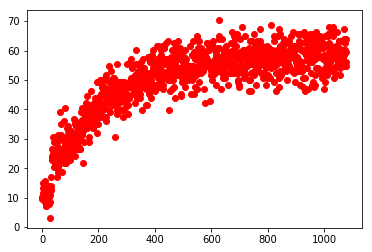

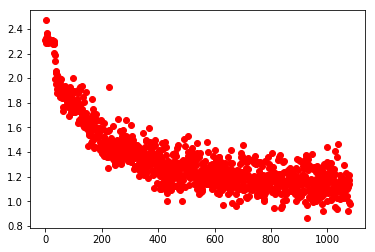

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

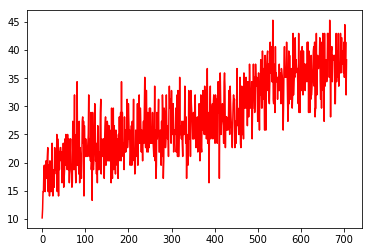

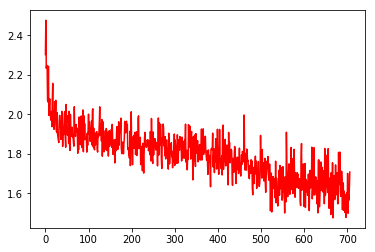

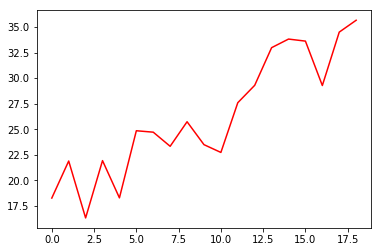

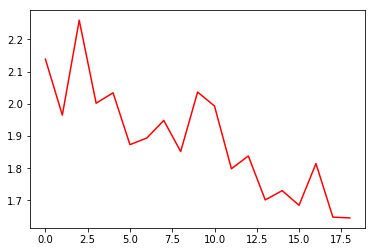

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()